In [1]:
!pip install --quiet numpy==1.25.2 scipy tensorflow==2.14.1 tensorflow_federated==0.84.0

In [2]:
import pandas as pd
import numpy as np

Load MovieLens 1M Data (Handles Encoding)


In [3]:
# Use ISO-8859-1 encoding as per dataset documentation and community advice[5][6]
users = pd.read_csv('/content/users.dat', sep='::', engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
                    encoding='ISO-8859-1')
ratings = pd.read_csv('/content/ratings.dat', sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                      encoding='ISO-8859-1')
movies = pd.read_csv('/content/movies.dat', sep='::', engine='python',
                     names=['MovieID', 'Title', 'Genres'],
                     encoding='ISO-8859-1')

# Map user and movie IDs to indices
user_id_map = {uid: idx for idx, uid in enumerate(users['UserID'].unique())}
movie_id_map = {mid: idx for idx, mid in enumerate(movies['MovieID'].unique())}

num_users = len(user_id_map)
num_movies = len(movie_id_map)

# Build binary user-movie request matrix
request_matrix = np.zeros((num_users, num_movies), dtype=np.int8)
for row in ratings.itertuples():
    uidx = user_id_map[row.UserID]
    midx = movie_id_map[row.MovieID]
    request_matrix[uidx, midx] = 1

print(f"Users: {num_users}, Movies: {num_movies}, Matrix shape: {request_matrix.shape}")


Users: 6040, Movies: 3883, Matrix shape: (6040, 3883)


 Simulation Parameters and Device Initialization

In [4]:
# Simulation parameters from your table[3][4]
N = 10  # Number of devices
users_per_device = num_users // N

np.random.seed(42)
devices = []
for n in range(N):
    start = n * users_per_device
    end = (n + 1) * users_per_device if n < N - 1 else num_users
    Xn = request_matrix[start:end]
    Dn = np.random.randint(20, 51)
    wn = np.random.uniform(50, 100) * 8 * 1e6  # MB to bits
    alpha_n = np.random.uniform(18, 20.5) * 1e5
    Cn = np.random.randint(40, 61)
    Pn = np.random.uniform(0.01, 0.05)
    gamma_n = 10  # SNR (linear)
    # Cosine similarity
    if Xn.shape[0] > 1:
        sims = []
        for i in range(Xn.shape[0]):
            for j in range(i+1, Xn.shape[0]):
                a, b = Xn[i], Xn[j]
                if np.linalg.norm(a) and np.linalg.norm(b):
                    sims.append(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
        rho_n = np.mean(sims) if sims else 0.0
    else:
        rho_n = 0.0
    devices.append({
        'Xn': Xn,
        'Dn': Dn,
        'wn': wn,
        'alpha_n': alpha_n,
        'Cn': Cn,
        'Pn': Pn,
        'gamma_n': gamma_n,
        'rho_n': rho_n,
        'z_n': Xn.sum()
    })


Latency and Energy Calculation

In [5]:
def calc_latency_energy(dev):
    wS = 75 * 8 * 1e6  # 75 MB in bits
    Bdn_S = 150e6
    Bup_n = 100e6
    mu_n = 1
    f_n = 1e9
    beta_n = 1e-27
    P_dn_S = 1.0

    t_dn = wS / (Bdn_S * np.log2(1 + dev['gamma_n']))
    e_dn = P_dn_S * t_dn
    t_comp = mu_n * dev['Cn'] * dev['Dn'] / f_n
    e_comp = beta_n * mu_n * dev['Cn'] * dev['Dn'] * f_n ** 2
    t_up = dev['wn'] / (Bup_n * np.log2(1 + dev['gamma_n']))
    e_up = dev['Pn'] * t_up
    return t_dn + t_comp + t_up, e_dn + e_comp + e_up

for dev in devices:
    dev['t_n'], dev['e_n'] = calc_latency_energy(dev)


Device Selection Optimization (Constraints 1a–1j)

In [6]:
!pip install cvxpy
!pip install ecos


Define Parameters

In [7]:
# Define simulation parameters from your constraint table
params = {
    'z_min': 800,
    'z_max': 7000,
    'D_max': 40,
    't_max': 1e-3,      # 1 ms
    'e_max': 1e-3,      # 1 mJ
    'S_min': 2,
    'S_max': 10         # Use 10 as per your table
}

print("Parameters defined:", params)


Parameters defined: {'z_min': 800, 'z_max': 7000, 'D_max': 40, 't_max': 0.001, 'e_max': 0.001, 'S_min': 2, 'S_max': 10}


In [12]:
import cvxpy as cp
def device_selection_with_offloading(devices, params):
    N = len(devices)
    # Decision variables
    s = cp.Variable(N, boolean=True)           # Device selection
    phi = cp.Variable((N, N), nonneg=True)     # Offloading fractions
    t = cp.Variable(nonneg=True)               # Round latency

    # Device parameters
    z = np.array([d['z_n'] for d in devices])
    rho = np.array([d['rho_n'] for d in devices])
    D = np.array([d['Dn'] for d in devices])
    t_n = np.array([d['t_n'] for d in devices])
    e_n = np.array([d['e_n'] for d in devices])
    alpha = np.array([d['alpha_n'] for d in devices])

    # Normalize rho for numerical stability
    rho_norm = rho / (np.max(rho) + 1e-10)

    # Objective: maximize sum(s_n * z_n * rho_n)
    objective = cp.Maximize(cp.sum(cp.multiply(s, z * rho_norm)))

    constraints = []

    # 1a: Variable bounds (handled by cp.Variable)
    constraints += [phi <= 1]

    # 1b: s_n*z_n + (1-s_n)*z_min >= z_min
    constraints += [cp.multiply(s, z) + cp.multiply(1 - s, params['z_min']) >= params['z_min']]

    # 1c: (1-s_n)*z_n + alpha_n*t <= z_max
    constraints += [cp.multiply(1 - s, z) + cp.multiply(alpha, t) <= params['z_max']]

    # 1d: s_n*Dn <= D_max
    constraints += [cp.multiply(s, D) <= params['D_max']]

    # 1e: t <= t_max, t >= max(s_n * t_n)
    constraints += [t <= params['t_max']]
    constraints += [t >= cp.max(cp.multiply(s, t_n))]

    # 1f: s_n*e_n <= e_max
    constraints += [cp.multiply(s, e_n) <= params['e_max']]

    # 1g: S_min <= sum(s_n) <= S_max
    constraints += [cp.sum(s) >= params['S_min']]
    constraints += [cp.sum(s) <= params['S_max']]

    # 1h: sum_m phi_mn <= 1 for all n
    constraints += [cp.sum(phi, axis=0) <= 1]

    # 1i: (1-s_n)(1-s_m)phi_nm = 0  (linearized: phi_nm <= s_n + s_m)
    for n in range(N):
        for m in range(N):
            if n != m:
                constraints.append(phi[n, m] <= s[n] + s[m])

    # 1j: s_n * phi_nm = 0 (linearized: phi_nm <= 1 - s_n)
    for n in range(N):
        for m in range(N):
            if n != m:
                constraints.append(phi[n, m] <= 1 - s[n])

    # Solve the problem
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.ECOS_BB, verbose=False)

        if prob.status == cp.OPTIMAL:
            selected = (s.value > 0.5).astype(int)
            phi_val = phi.value
        else:
            # Fallback: greedy selection
            scores = z * rho_norm
            selected_idx = np.argsort(scores)[-params['S_max']:]
            selected = np.zeros(N, dtype=int)
            selected[selected_idx] = 1
            phi_val = np.zeros((N, N))

    except Exception as e:
        print(f"Optimization failed: {e}")
        # Fallback: greedy selection
        scores = z * rho_norm
        selected_idx = np.argsort(scores)[-params['S_max']:]
        selected = np.zeros(N, dtype=int)
        selected[selected_idx] = 1
        phi_val = np.zeros((N, N))

    return selected, phi_val


Federated Learning Preparation (Autoencoder Model)

In [13]:
import tensorflow as tf
import tensorflow_federated as tff
def create_tf_dataset(device):
    x = device['Xn'].astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((x, x))
    return ds.batch(10)

def model_fn(num_movies):
    keras_model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(num_movies,)),
        tf.keras.layers.Dense(num_movies, activation='sigmoid')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=(tf.TensorSpec([None, num_movies], tf.float32), tf.TensorSpec([None, num_movies], tf.float32)),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )


Federated Learning Simulation Loop


In [14]:
num_movies = devices[0]['Xn'].shape[1]
rounds = 15

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=lambda: model_fn(num_movies),
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(1e-4),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(1e-3)
)
state = iterative_process.initialize()

history = []

for round_num in range(rounds):
    print(f"=== FL Round {round_num+1} ===")
    selected, phi = device_selection_with_offloading(devices, params)
    selected_idx = np.where(selected == 1)[0]
    print(f"Selected devices: {selected_idx}")

    federated_train_data = [create_tf_dataset(devices[i]) for i in selected_idx]
    if not federated_train_data:
        print("No devices selected this round.")
        continue

    result = iterative_process.next(state, federated_train_data)
    state = result.state
    loss = float(result.metrics['client_work']['train']['loss'])
    print(f"FL Loss: {loss:.4f}")

    history.append({
        'round': round_num+1,
        'selected': selected,
        'phi': phi,
        'loss': loss
    })

print(f"Completed {len(history)} rounds of federated learning")


=== FL Round 1 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2484
=== FL Round 2 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2479
=== FL Round 3 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2474
=== FL Round 4 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2468
=== FL Round 5 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2462
=== FL Round 6 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2456
=== FL Round 7 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2450
=== FL Round 8 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2444
=== FL Round 9 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2438
=== FL Round 10 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2432
=== FL Round 11 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2425
=== FL Round 12 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2419
=== FL Round 13 ===
Selected devices: [0 1 2 3 4 5 6 7 8 9]
FL Loss: 0.2413
=== FL Round 14 ===
S

Content Popularity Prediction

In [15]:
# Extract final model for prediction
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(num_movies,)),
    tf.keras.layers.Dense(num_movies, activation='sigmoid')
])

# Predict popularity using identity matrix
all_movies = np.eye(num_movies, dtype=np.float32)
popularity_scores = keras_model.predict(all_movies, verbose=0).mean(axis=0)
top_movies = np.argsort(popularity_scores)[::-1]

print(f"Top 10 most popular movie indices: {top_movies[:10]}")


Top 10 most popular movie indices: [ 831 2462 2133 1180 1799  354 1990 3286 3822 2310]


Cache Efficiency Calculation

In [16]:
def cache_efficiency(top_movies, devices, cache_sizes=[50, 100, 200, 300, 500]):
    efficiencies = []
    for cache_size in cache_sizes:
        cached = set(top_movies[:cache_size])
        total, hits = 0, 0
        for dev in devices:
            for user in dev['Xn']:
                requested = np.where(user == 1)[0]
                total += len(requested)
                hits += len(set(requested) & cached)
        eff = hits / total if total else 0
        efficiencies.append(eff)
    return cache_sizes, efficiencies

cache_sizes, efficiencies = cache_efficiency(top_movies, devices)

print("\n=== CACHE EFFICIENCY RESULTS ===")
for size, eff in zip(cache_sizes, efficiencies):
    print(f"Cache size {size}: Efficiency {eff*100:.2f}%")

max_eff = max(efficiencies)
best_cache_size = cache_sizes[np.argmax(efficiencies)]
print(f"\nBest cache efficiency: {max_eff*100:.2f}% at cache size {best_cache_size}")



=== CACHE EFFICIENCY RESULTS ===
Cache size 50: Efficiency 1.28%
Cache size 100: Efficiency 2.76%
Cache size 200: Efficiency 5.44%
Cache size 300: Efficiency 8.10%
Cache size 500: Efficiency 13.25%

Best cache efficiency: 13.25% at cache size 500


Results Visualization

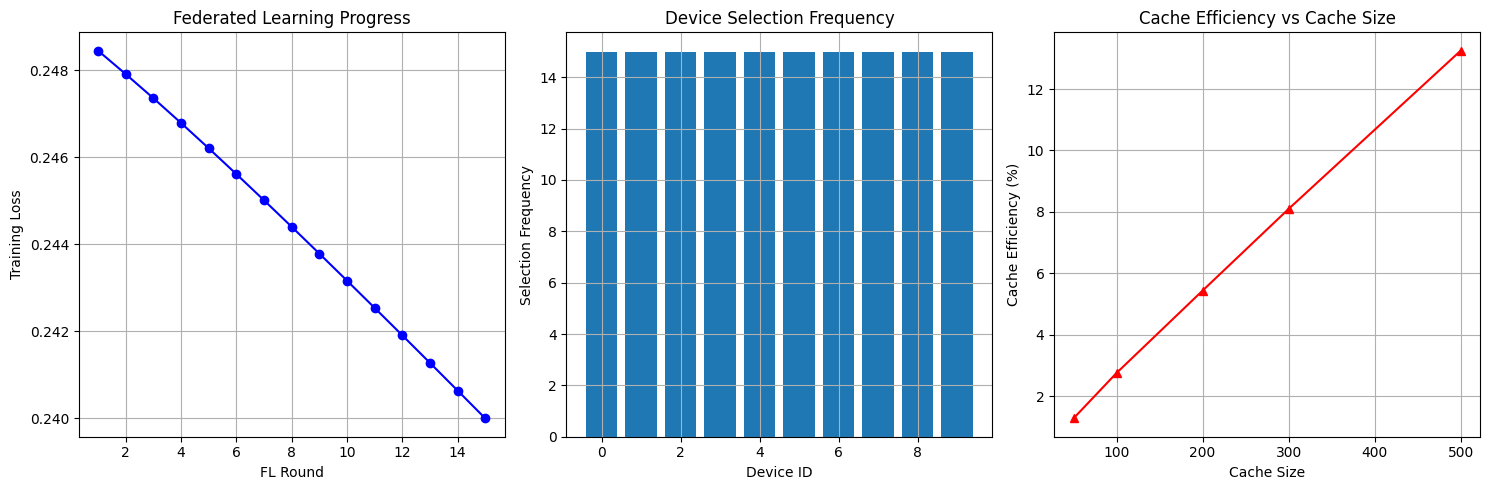


=== FINAL SUMMARY ===
Completed rounds: 15
Final training loss: 0.2400
Average devices selected per round: 10.00
Maximum cache efficiency achieved: 13.25%


In [18]:
import matplotlib.pyplot as plt
# Plot training progress
plt.figure(figsize=(15, 5))

# Plot 1: Training loss
plt.subplot(1, 3, 1)
rounds_completed = [h['round'] for h in history]
losses = [h['loss'] for h in history]
plt.plot(rounds_completed, losses, 'b-o')
plt.xlabel('FL Round')
plt.ylabel('Training Loss')
plt.title('Federated Learning Progress')
plt.grid(True)

# Plot 2: Device selection frequency
plt.subplot(1, 3, 2)
device_selection_count = np.zeros(len(devices))
for h in history:
    device_selection_count += h['selected']
plt.bar(range(len(devices)), device_selection_count)
plt.xlabel('Device ID')
plt.ylabel('Selection Frequency')
plt.title('Device Selection Frequency')
plt.grid(True)

# Plot 3: Cache efficiency
plt.subplot(1, 3, 3)
plt.plot(cache_sizes, [e*100 for e in efficiencies], 'r-^')
plt.xlabel('Cache Size')
plt.ylabel('Cache Efficiency (%)')
plt.title('Cache Efficiency vs Cache Size')
plt.grid(True)

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== FINAL SUMMARY ===")
print(f"Completed rounds: {len(history)}")
print(f"Final training loss: {losses[-1]:.4f}")
print(f"Average devices selected per round: {np.mean([np.sum(h['selected']) for h in history]):.2f}")
print(f"Maximum cache efficiency achieved: {max_eff*100:.2f}%")
